# Az adatállományról
Kontextus

Ez az adatkészlet 21000 képet tartalmaz.
Ebből az első 16 legtöb képet tartalmazó osztályt használtam a tanításra, ezekből is egyenként 400 képet vettem ki.
Ezt az adathalmazt arra használhatja, hogy felismerje a közlekedési táblákat a fotóról.

Tartalom

A képek 16 osztályba vannak osztva: no_stopping, watch_out_for_cars, speed_limit_60kmh, speed_limit_40kmh,speed_limit_30kmh, speed_limit_50kmh, bicycles_crossing, speed_limit_80kmh, zebra_crossing, no_horn, keep_right, dont_go_left, speed_limit_70kmh, no_entry, no_car.
Minden osztályhoz körülbelül 400 fotót rendelünk hozzá. A fényképek nem nagy felbontásúak, körülbelül 100x100 pixelesek.

# Traffic Sign Recognition CNN Keras

TARTALOM :
1.   Különböző modulok importálása
2.   Az adatok előkészítése
3.   Modellezés
4.   Túltantás
5.   A modell teljesítményének értékelése
6.   Előrejelzések vizualizálása a validációs készleten


## 1 ) Különböző modulok importálása.

In [1]:
!nvidia-smi

Mon May  6 07:45:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.3 MB/s eta 0:00:00


In [4]:
# Figyelmen kívül hagyja a figyelmeztetéseket
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# adatvizualizáció és -manipuláció
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import style
import seaborn as sns
import visualkeras
from keras.layers import LeakyReLU

#configure
# a matplotlib-ot inline-ra állítja, és megjeleníti a grafikonokat a megfelelő cella alatt.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#modell kiválasztása
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder

#előfeldolgozás.
from keras.preprocessing.image import ImageDataGenerator

#dl könyvtárak
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.regularizers import l2

# kifejezetten a CNN részére
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D

import tensorflow as tf
import random as rn

# kifejezetten a zippelt képek manipulálására és a képek pixelértékeit tartalmazó numpy tömbök kinyerésére.
import cv2
import os
from tqdm import tqdm

## 2 ) Az adatok előkészítése

## 2.1) A Képekből a gyakorló és a validációs készlet kinyerésére szolgáló függvények elkészítése

In [5]:
X=[]
Z=[]
IMG_SIZE=128
FOLDER_NAME_EXCEPTIONS = ['unknown']

# TODO read the info.csv file and get the first column as labels
info_csv = pd.read_csv("/content/drive/My Drive/TrafficSignCNN/final_dataset/info.csv")
# CSV structure
# Folder Name,	Number of Images,	Keyword1,	Keyword2,	Keyword3,	Keyword4,	Keyword5,	Keyword6,	Keyword7
# no_stopping,	1077,	no,	stopping,
# ...

# get the first 16 folder names without the exceptions
folder_names = info_csv["Folder Name"][:16]
folder_names = folder_names[~folder_names.isin(FOLDER_NAME_EXCEPTIONS)]
display(folder_names)

0            no_stopping
1     watch_out_for_cars
2      speed_limit_60kmh
3      speed_limit_40kmh
5      speed_limit_30kmh
6      speed_limit_50kmh
7      bicycles_crossing
8      speed_limit_80kmh
9         zebra_crossing
10               no_horn
11            keep_right
12          dont_go_left
13     speed_limit_70kmh
14              no_entry
15                no_car
Name: Folder Name, dtype: object

In [6]:
def assign_label(img,img_type):
    return img_type

In [7]:
def make_train_data(img_type, DIR, max_images_per_class=400):
    class_count = 0

    for img in os.listdir(DIR):
        if class_count >= max_images_per_class:
            break

        label = assign_label(img, img_type)

        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        im_rgb = cv2.resize(im_rgb, (IMG_SIZE, IMG_SIZE))

        X.append(np.array(im_rgb))
        Z.append(str(label))

        class_count += 1

    print(f"Processed {class_count} images for class: {img_type}")


In [8]:
# for each folder in folder_names lets assign the foldername as a label
for folder_name in folder_names:
    print(folder_name)
    make_train_data(folder_name,f"/content/drive/My Drive/TrafficSignCNN/final_dataset/{folder_name}")
    print(len(X))

no_stopping
Processed 400 images for class: no_stopping
400
watch_out_for_cars
Processed 400 images for class: watch_out_for_cars
800
speed_limit_60kmh
Processed 400 images for class: speed_limit_60kmh
1200
speed_limit_40kmh
Processed 400 images for class: speed_limit_40kmh
1600
speed_limit_30kmh
Processed 400 images for class: speed_limit_30kmh
2000
speed_limit_50kmh
Processed 400 images for class: speed_limit_50kmh
2400
bicycles_crossing
Processed 400 images for class: bicycles_crossing
2800
speed_limit_80kmh
Processed 400 images for class: speed_limit_80kmh
3200
zebra_crossing
Processed 400 images for class: zebra_crossing
3600
no_horn
Processed 400 images for class: no_horn
4000
keep_right
Processed 400 images for class: keep_right
4400
dont_go_left
Processed 400 images for class: dont_go_left
4800
speed_limit_70kmh
Processed 400 images for class: speed_limit_70kmh
5200
no_entry
Processed 400 images for class: no_entry
5600
no_car
Processed 400 images for class: no_car
6000


## 2.2 ) Visualizing the Classes

In [9]:
import random

# Initialize a dictionary to store the count of images in each class
class_count = {}
data_dir = "/content/drive/My Drive/TrafficSignCNN/final_dataset"
# Iterate over the directories in the data directory
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of files in the directory (assuming each file is an image)
        num_images = len(os.listdir(class_dir))
        # Store the count for this class
        class_count[class_name] = num_images

# Sort classes by image count in ascending order
sorted_classes = sorted(class_count.items(), key=lambda x: x[1])

# Extract class names and image counts
class_names = [item[0] for item in sorted_classes]
image_counts = [item[1] for item in sorted_classes]

# Define 16 custom colors for each bar
colors = ['#' + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(class_names))]

# Create a bar plot using Plotly
fig = go.Figure(data=[go.Bar(
    x=image_counts,
    y=class_names,
    orientation='h',
    marker_color=colors,
)])

# Customize layout
fig.update_layout(
    title='Number of Images in Each Class',
    xaxis_title='Number of Images',
    yaxis_title='Class',
    yaxis=dict(autorange="reversed"),  # Invert y-axis to have the class with the highest count at the top
)

# Show plot
fig.show()

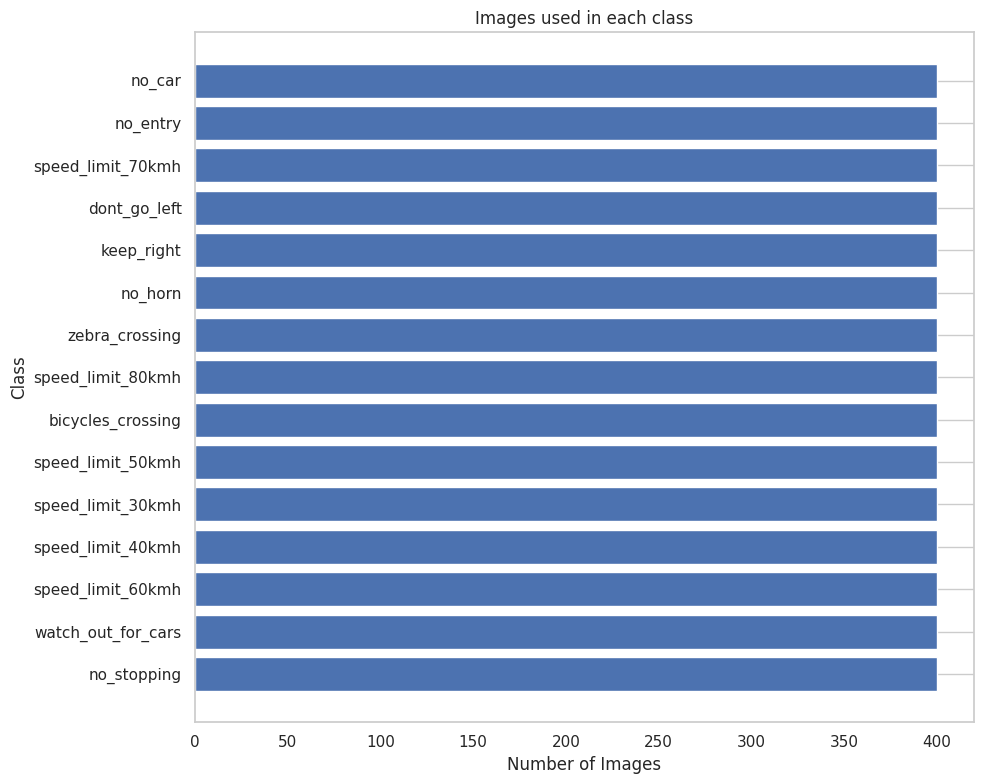

In [10]:
plt.figure(figsize=(10, 8))
plt.title('Images used in each class')

# Create a dictionary to store the count of images for each class
class_counts = {folder_name: 400 for folder_name in folder_names}

# Plot the histogram
plt.barh(range(len(folder_names)), list(class_counts.values()), height=0.8)

# Set the tick labels to the folder names
plt.yticks(range(len(folder_names)), folder_names)

plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

## 2.2 ) Néhány véletlenszerű kép vizualizációja

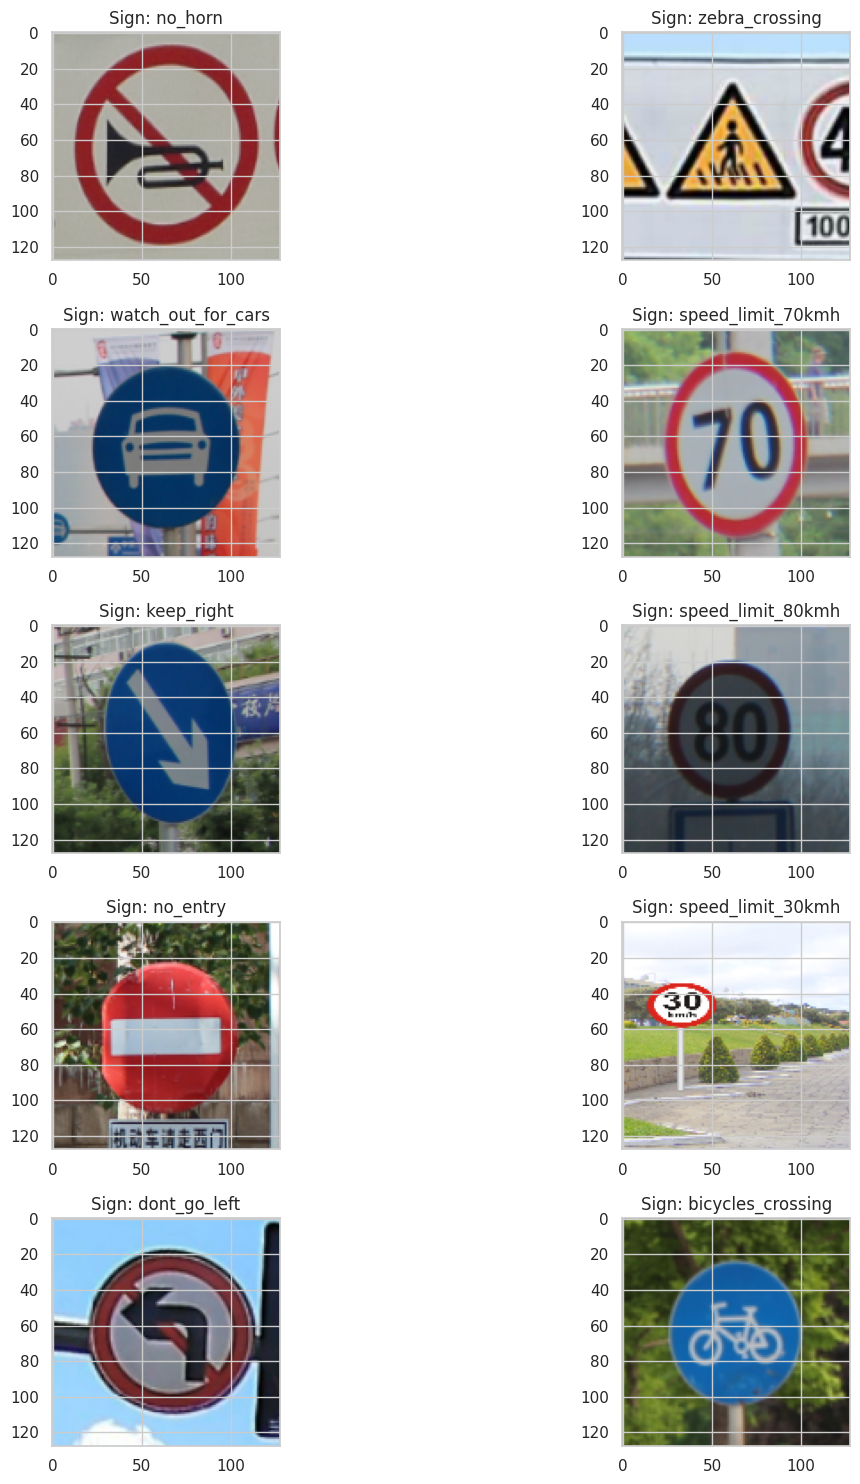

In [11]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Sign: '+Z[l])

plt.tight_layout()

## 2.3 ) Címkekódolás az Y tömbben majd One Hot Encoding

In [12]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,16)
X=np.array(X)
X=X/255

## 2.4 ) Felosztás képzési és validálási halmazokra

In [13]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

## 2.5 ) A véletlen magok beállítása

In [14]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## 3 ) Modellezés

## 3.1 ) A ConvNet modell felépítése

In [26]:
# # modelling starts using a CNN.
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 256, kernel_size = (3,3)))
model.add(Conv2D(filters = 256, kernel_size = (3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(16, activation = "softmax"))

## 3.2 ) LR lágyító használata

In [27]:
batch_size=125
epochs=30

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Adatbővítés a túlillesztés megakadályozására

In [28]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # a bemeneti átlagot 0-ra állítja az adathalmazon
        samplewise_center=False,  # minden minta átlagát 0-ra állítsuk
        featurewise_std_normalization=False,  # a bemenetek osztása az adatállomány std értékével
        samplewise_std_normalization=False,  # osszuk el az egyes bemeneteket az std
        zca_whitening=False,  # alkalmazni ZCA fehérítés
        rotation_range=10,  # véletlenszerűen forgatja a képeket a (0 és 20 fok közötti) tartományban.
        zoom_range=0.15,  # Kép véletlenszerű nagyítása (0.8 és 1.2 közötti tartomány)
        width_shift_range=0.01,  # a képek véletlenszerű vízszintes eltolása (a teljes szélesség 1%-a)
        height_shift_range=0.01,  # a képek véletlenszerű függőleges eltolása (a teljes magasság 1%-a)
        shear_range=0.15,  # véletlenszerű nyírási transzformáció (0 és 0.15 közötti tartomány)
        horizontal_flip=True,  # véletlenszerűen flip képek vízszintesen
        vertical_flip=True,  # ne alkalmazzunk függőleges flip-et
        )  # kitöltési mód a transzformált képeken kívüli pontokhoz

datagen.fit(x_train)

## 3.4 ) A Keras modell fordítása és összefoglaló

In [29]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 conv2d_9 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 120, 120, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 58, 58, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 64)        36928     
                                                      

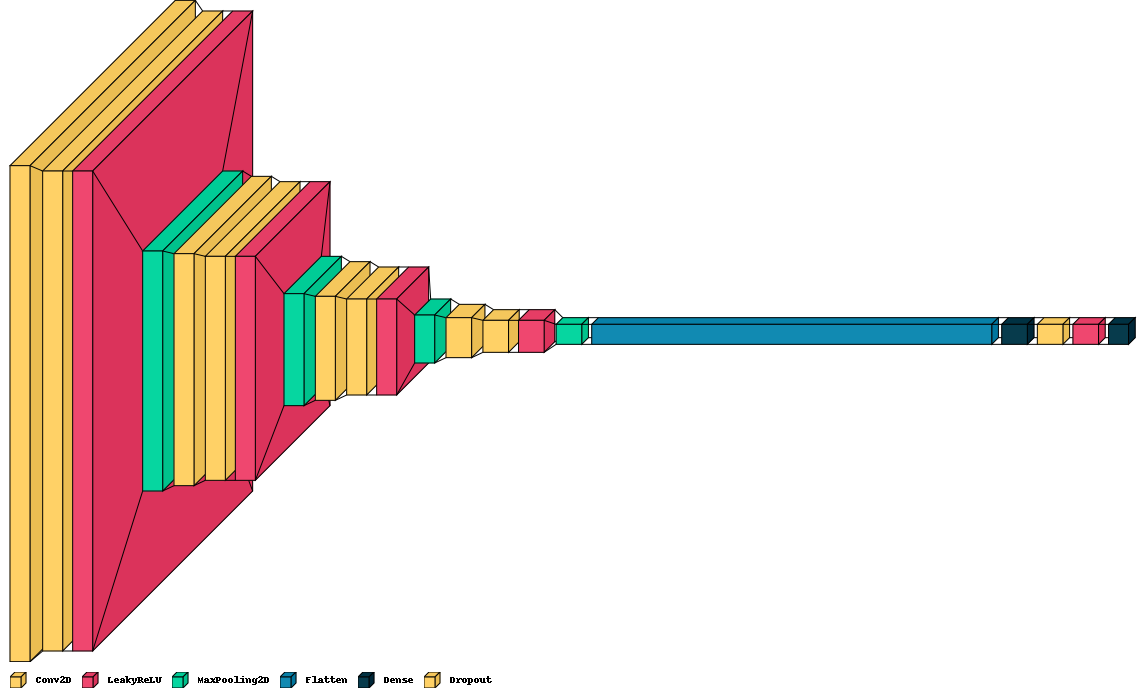

In [31]:
visualkeras.layered_view(model, legend=True)

## 3.5 ) Illesztés a gyakorlóhalmazon és előrejelzések készítése a validációs halmazon

In [32]:
History = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# History = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/30
36/36 [==============================] - 19s 440ms/step - loss: 2.6658 - accuracy: 0.1044 - val_loss: 2.1034 - val_accuracy: 0.2273
Epoch 2/30
36/36 [==============================] - 16s 428ms/step - loss: 1.7657 - accuracy: 0.3911 - val_loss: 1.1331 - val_accuracy: 0.6100
Epoch 3/30
36/36 [==============================] - 16s 431ms/step - loss: 0.9304 - accuracy: 0.6727 - val_loss: 0.6084 - val_accuracy: 0.8160
Epoch 4/30
36/36 [==============================] - 16s 433ms/step - loss: 0.6183 - accuracy: 0.7927 - val_loss: 0.3613 - val_accuracy: 0.8893
Epoch 5/30
36/36 [==============================] - 16s 432ms/step - loss: 0.4904 - accuracy: 0.8380 - val_loss: 0.3243 - val_accuracy: 0.9000
Epoch 6/30
36/36 [==============================] - 16s 434ms/step - loss: 0.3425 - accuracy: 0.8889 - val_loss: 0.1873 - val_accuracy: 0.9387
Epoch 7/30
36/36 [==============================] - 16s 433ms/step - loss: 0.2825 - accuracy: 0.9089 - val_loss: 0.1941 - val_accuracy: 0.9427

In [33]:
model.save('/content/drive/My Drive/TrafficSignCNN/traffic-sign-cnn.keras')

## 4 ) A modell teljesítményének értékelése

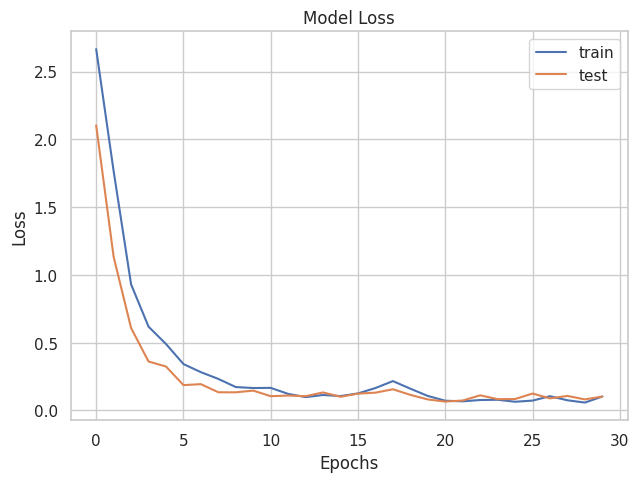

In [34]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [35]:
print(History.history)

{'loss': [2.6657962799072266, 1.7656530141830444, 0.9303707480430603, 0.6183119416236877, 0.4904330372810364, 0.3425406813621521, 0.2824910283088684, 0.23270949721336365, 0.17270924150943756, 0.16576996445655823, 0.1668059080839157, 0.12231025844812393, 0.09857495129108429, 0.11428458988666534, 0.10635454952716827, 0.12583647668361664, 0.1656193733215332, 0.21687453985214233, 0.16070331633090973, 0.10732197761535645, 0.07196806371212006, 0.06757105886936188, 0.0772605687379837, 0.07905755937099457, 0.06444752216339111, 0.0728616788983345, 0.10540012270212173, 0.07528898864984512, 0.058335185050964355, 0.1030464917421341], 'accuracy': [0.10444444417953491, 0.3911111056804657, 0.6726666688919067, 0.7926666736602783, 0.8379999995231628, 0.8888888955116272, 0.9088888764381409, 0.9264444708824158, 0.9402222037315369, 0.9493333101272583, 0.9480000138282776, 0.9582222104072571, 0.9684444665908813, 0.9622222185134888, 0.9660000205039978, 0.9595555663108826, 0.9486666917800903, 0.93511110544204

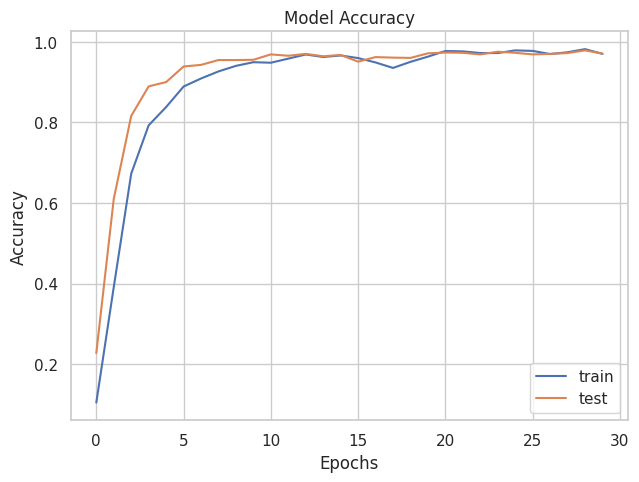

In [36]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## 5 ) Előrejelzések vizualizálása a validációs készleten

In [42]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

47/47 [==============================] - 1s 16ms/step


In [43]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

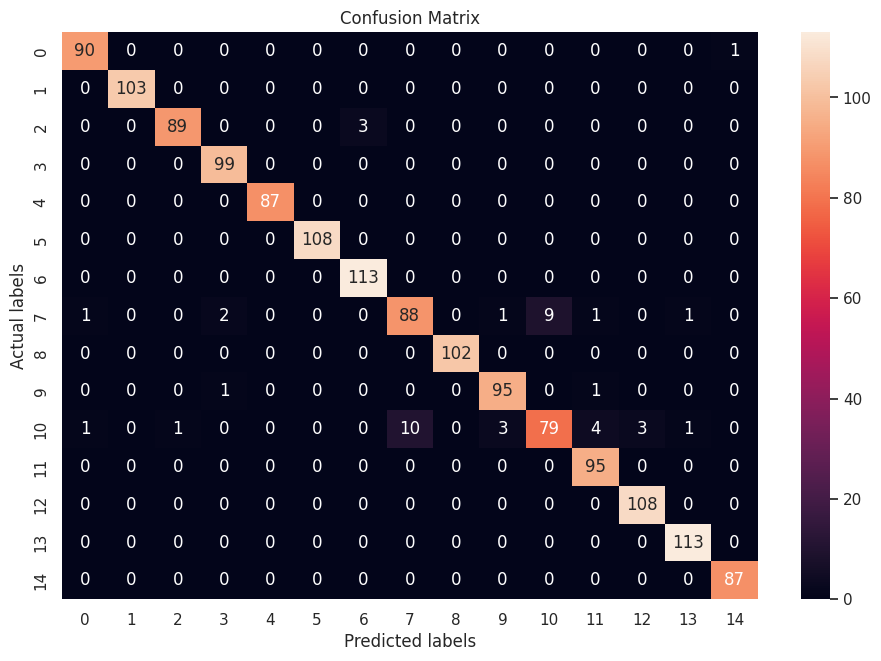

In [44]:
# Creating and plotting confusion matrix

y_test_argmax = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_argmax, pred_digits)  # Use pred_digits instead of pred

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

In [45]:
# Save statistics to csv
def perf_measure_metrics(y_test, y_pred, CM, filename):
    metrics = []

    for i in range(len(np.unique(y_test))):  # Ensure it covers all classes
        TP = CM[i][i]
        FP = CM[i,:].sum() - TP
        FN = CM[:,i].sum() - TP
        TN = CM.sum() - TP - FP - FN

        metrics.append({
            "Class": str(i),
            "True Positive": TP,
            "False Positive": FP,
            "False Negative": FN,
            "True Negative": TN,
            "Accuracy": (TP + TN) / (TP + FP + FN + TN),
            "Precision": TP / (TP + FP) if (TP + FP) != 0 else 0,
            "Recall": TP / (TP + FN) if (TP + FN) != 0 else 0,
            "F1 Score": 2*TP / (2*TP + FP + FN) if (2*TP + FP + FN) != 0 else 0
        })

    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv(filename, index=False)

In [46]:
perf_measure_metrics(y_test_argmax, pred, cm, '/content/drive/My Drive/TrafficSignCNN/detailed_metrics.csv')

#### HELYESEN OSZTÁLYOZOTT KÉPEK

In [47]:
print(le.inverse_transform([pred_digits[prop_class[0]]]))

['no_horn']


In [48]:
print([y_test[prop_class[0]]])

[array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)]


In [49]:
print(le.inverse_transform(np.argmax([y_test[prop_class[0]]], axis=1)))

['no_horn']


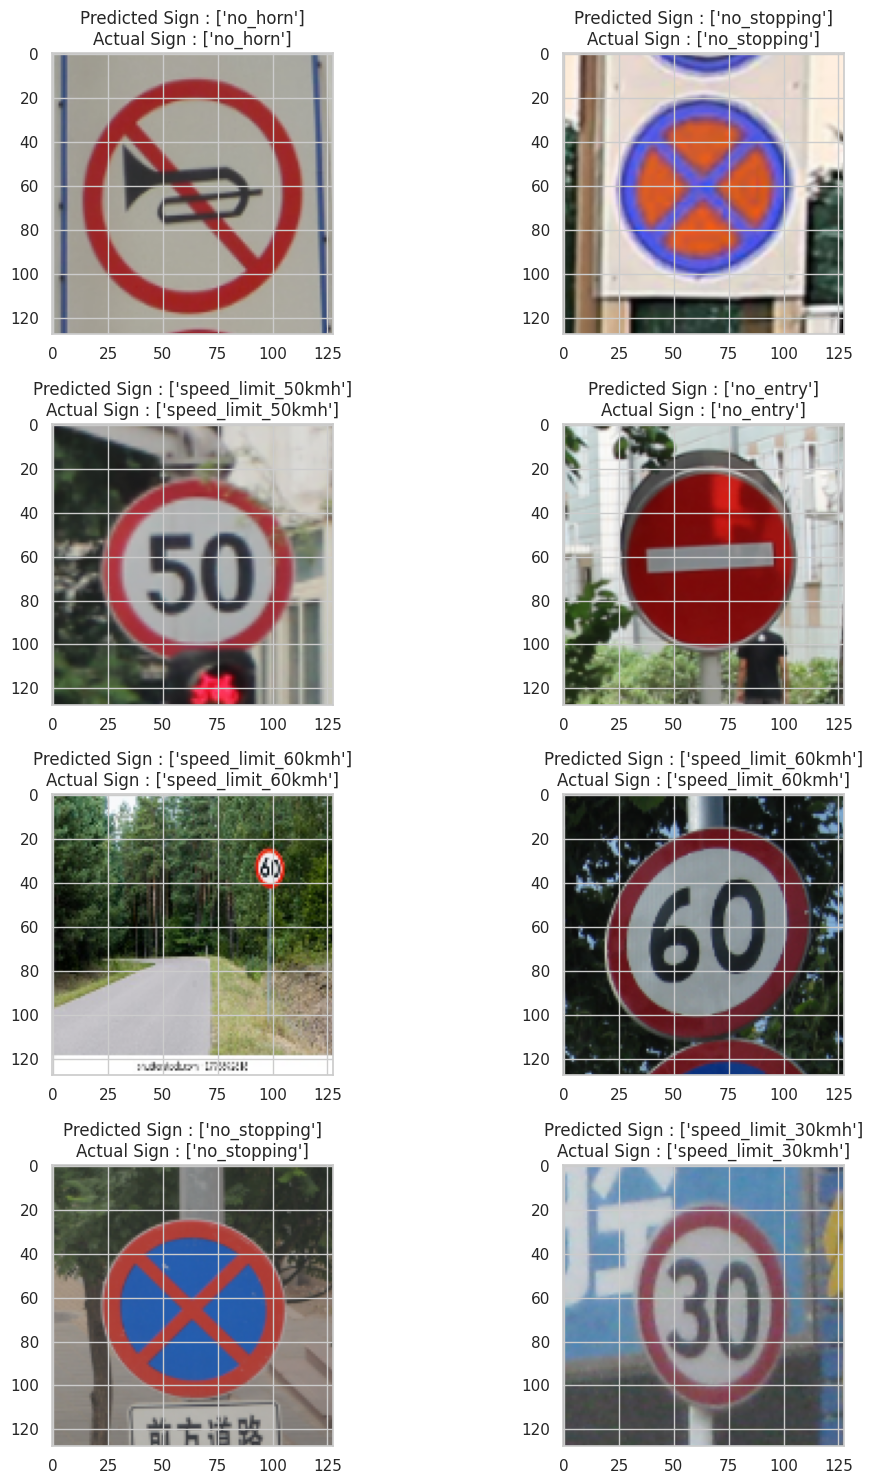

In [50]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Sign : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Sign : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]], axis=1))))
        plt.tight_layout()
        count+=1

#### TÉVESEN BESOROLT KÉPEK

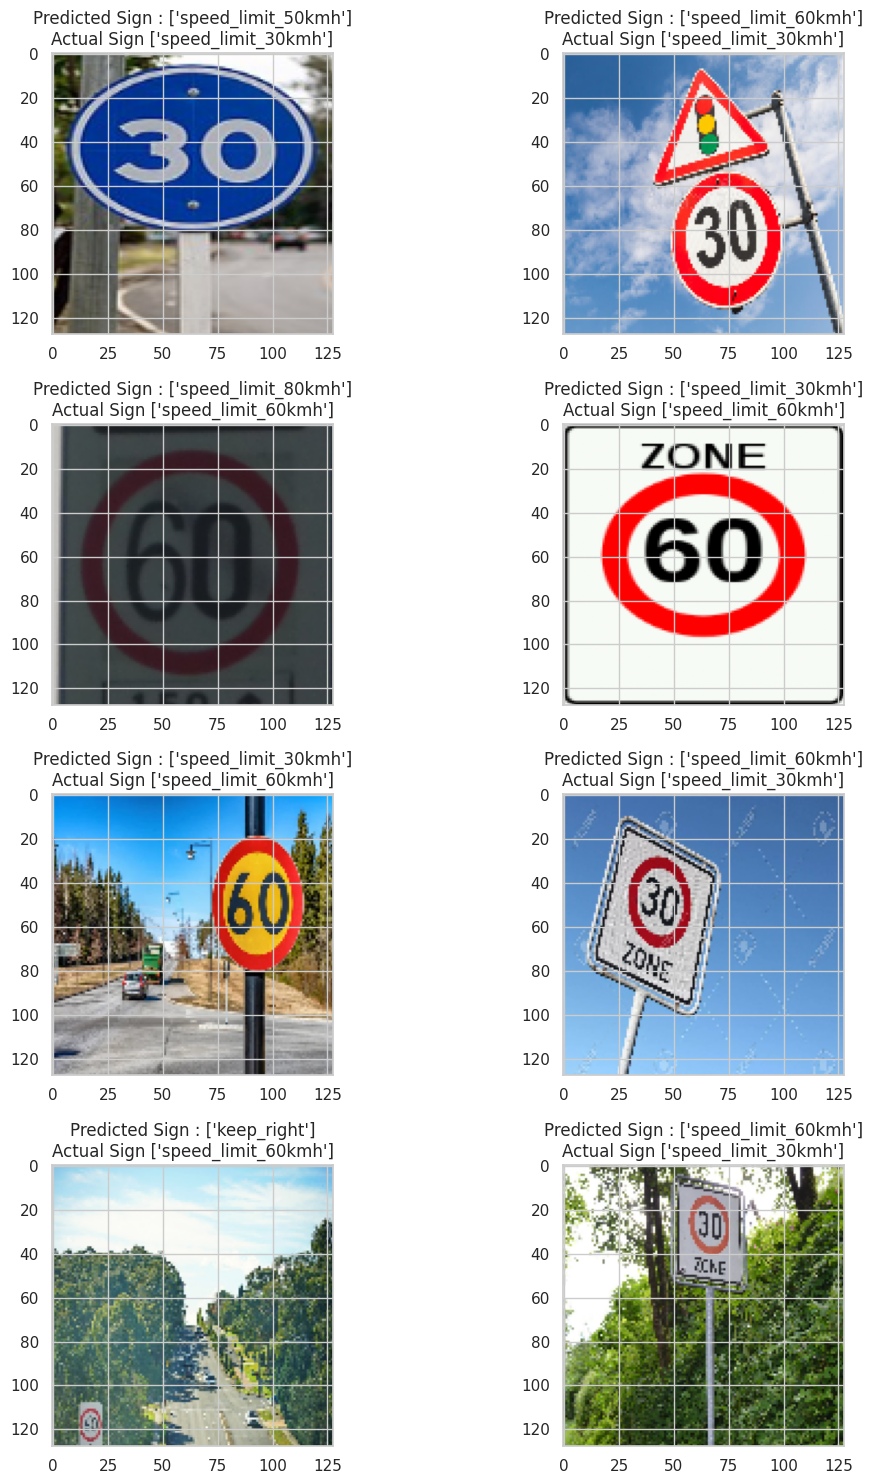

In [51]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Sign : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Sign "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]], axis=1))))
        plt.tight_layout()
        count+=1

# Túltanítás

In [52]:
X=[]
Z=[]
IMG_SIZE=128
FOLDER_NAME_EXCEPTIONS = ['unknown']

# TODO read the info.csv file and get the first column as labels
info_csv = pd.read_csv("/content/drive/My Drive/TrafficSignCNN/final_dataset/info.csv")
# CSV structure
# Folder Name,	Number of Images,	Keyword1,	Keyword2,	Keyword3,	Keyword4,	Keyword5,	Keyword6,	Keyword7
# no_stopping,	1077,	no,	stopping,
# ...

# get the first 16 folder names without the exceptions
folder_names = info_csv["Folder Name"][:16]
folder_names = folder_names[~folder_names.isin(FOLDER_NAME_EXCEPTIONS)]
display(folder_names)

0            no_stopping
1     watch_out_for_cars
2      speed_limit_60kmh
3      speed_limit_40kmh
5      speed_limit_30kmh
6      speed_limit_50kmh
7      bicycles_crossing
8      speed_limit_80kmh
9         zebra_crossing
10               no_horn
11            keep_right
12          dont_go_left
13     speed_limit_70kmh
14              no_entry
15                no_car
Name: Folder Name, dtype: object

In [53]:
# for each folder in folder_names lets assign the foldername as a label
for folder_name in folder_names:
    print(folder_name)
    make_train_data(folder_name,f"/content/drive/My Drive/TrafficSignCNN/final_dataset/{folder_name}",25)
    print(len(X))

no_stopping
Processed 25 images for class: no_stopping
25
watch_out_for_cars
Processed 25 images for class: watch_out_for_cars
50
speed_limit_60kmh
Processed 25 images for class: speed_limit_60kmh
75
speed_limit_40kmh
Processed 25 images for class: speed_limit_40kmh
100
speed_limit_30kmh
Processed 25 images for class: speed_limit_30kmh
125
speed_limit_50kmh
Processed 25 images for class: speed_limit_50kmh
150
bicycles_crossing
Processed 25 images for class: bicycles_crossing
175
speed_limit_80kmh
Processed 25 images for class: speed_limit_80kmh
200
zebra_crossing
Processed 25 images for class: zebra_crossing
225
no_horn
Processed 25 images for class: no_horn
250
keep_right
Processed 25 images for class: keep_right
275
dont_go_left
Processed 25 images for class: dont_go_left
300
speed_limit_70kmh
Processed 25 images for class: speed_limit_70kmh
325
no_entry
Processed 25 images for class: no_entry
350
no_car
Processed 25 images for class: no_car
375


In [54]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,16)
X=np.array(X)
X=X/255

In [59]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=42)

In [60]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [61]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[128, 128, 3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 59, 59, 128)       73856     
                                                                 
 conv2d_24 (Conv2D)          (None, 57, 57, 256)       295168    
                                                                 
 conv2d_25 (Conv2D)          (None, 55, 55, 256)       590080    
                                                      

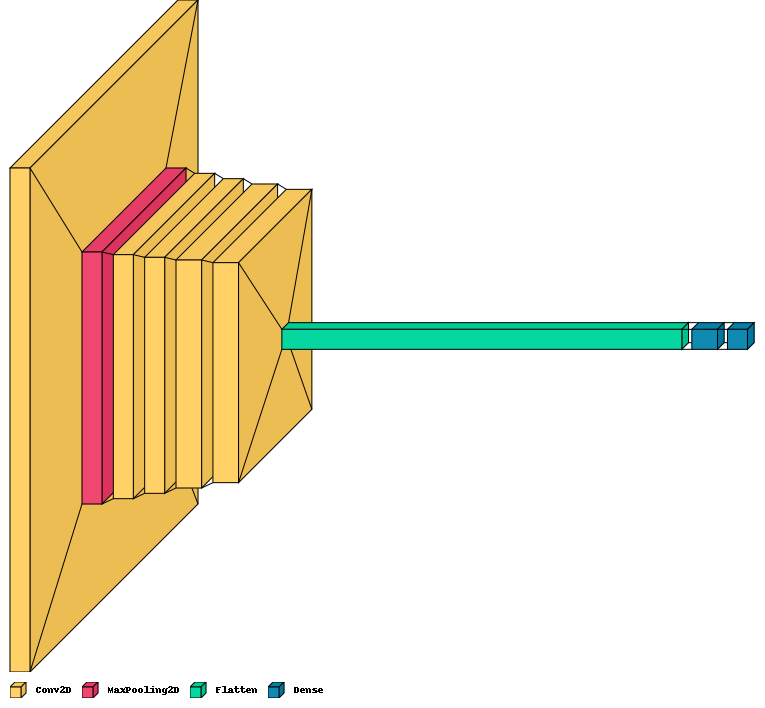

In [63]:
visualkeras.layered_view(cnn, legend=True)

In [64]:
history = cnn.fit(x_train,y_train, validation_data = (x_test,y_test), epochs=50, verbose=1, batch_size=10)

Epoch 1/50
34/34 [==============================] - 11s 174ms/step - loss: 3.1970 - accuracy: 0.0712 - val_loss: 2.5716 - val_accuracy: 0.1842
Epoch 2/50
34/34 [==============================] - 4s 104ms/step - loss: 2.4557 - accuracy: 0.2047 - val_loss: 2.4910 - val_accuracy: 0.2105
Epoch 3/50
34/34 [==============================] - 4s 116ms/step - loss: 1.9048 - accuracy: 0.3947 - val_loss: 2.0054 - val_accuracy: 0.2632
Epoch 4/50
34/34 [==============================] - 3s 90ms/step - loss: 1.4226 - accuracy: 0.5252 - val_loss: 1.8889 - val_accuracy: 0.3421
Epoch 5/50
34/34 [==============================] - 3s 88ms/step - loss: 1.0330 - accuracy: 0.6647 - val_loss: 1.9781 - val_accuracy: 0.3421
Epoch 6/50
34/34 [==============================] - 3s 88ms/step - loss: 0.9726 - accuracy: 0.6944 - val_loss: 2.1714 - val_accuracy: 0.3684
Epoch 7/50
34/34 [==============================] - 3s 87ms/step - loss: 0.6639 - accuracy: 0.7982 - val_loss: 4.2695 - val_accuracy: 0.4211
Epoch 8/5

In [66]:
model.save('/content/drive/My Drive/TrafficSignCNN/traffic-sign-cnn-overfit.keras')

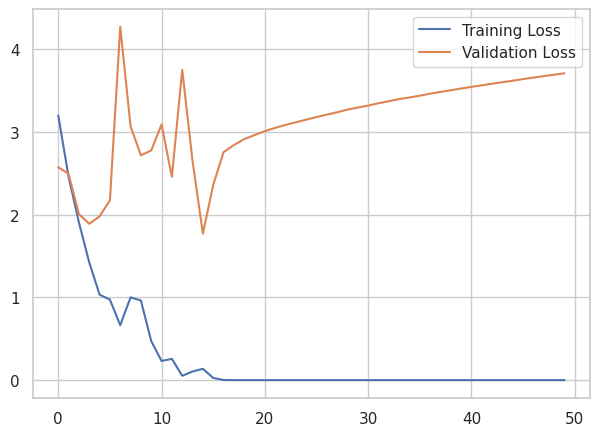

<Figure size 640x480 with 0 Axes>

In [67]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

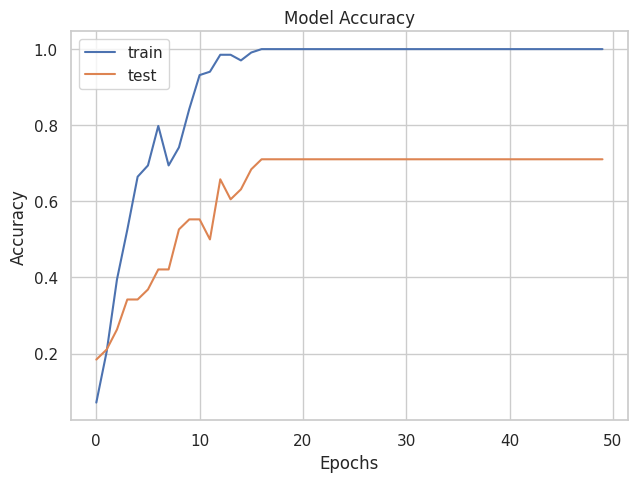

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [69]:
from sklearn.metrics import accuracy_score, classification_report
pred = cnn.predict(x_test)
pred=np.argmax(pred,axis=1)
y_test_argmax = np.argmax(y_test,axis=1)

2/2 [==============================] - 3s 626ms/step


In [70]:
clf_report = pd.DataFrame(classification_report(y_test_argmax, pred, output_dict=True))
print("Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test_argmax, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_argmax, pred)}\n")

Result:
Accuracy Score: 71.05%
_______________________________________________
CLASSIFICATION REPORT:
                  0         1    2    3    4         5         6         7  \
precision  0.800000  0.800000  1.0  0.5  1.0  1.000000  1.000000  0.666667   
recall     1.000000  1.000000  1.0  0.5  1.0  0.333333  0.750000  0.500000   
f1-score   0.888889  0.888889  1.0  0.5  1.0  0.500000  0.857143  0.571429   
support    4.000000  4.000000  2.0  2.0  1.0  3.000000  4.000000  4.000000   

             8    9        10   11        12        13  accuracy  macro avg  \
precision  0.0  0.0  0.600000  1.0  0.500000  1.000000  0.710526   0.704762   
recall     0.0  0.0  0.750000  1.0  1.000000  0.750000  0.710526   0.684524   
f1-score   0.0  0.0  0.666667  1.0  0.666667  0.857143  0.710526   0.671202   
support    1.0  2.0  4.000000  2.0  1.000000  4.000000  0.710526  38.000000   

           weighted avg  
precision      0.762281  
recall         0.710526  
f1-score       0.712824  
support

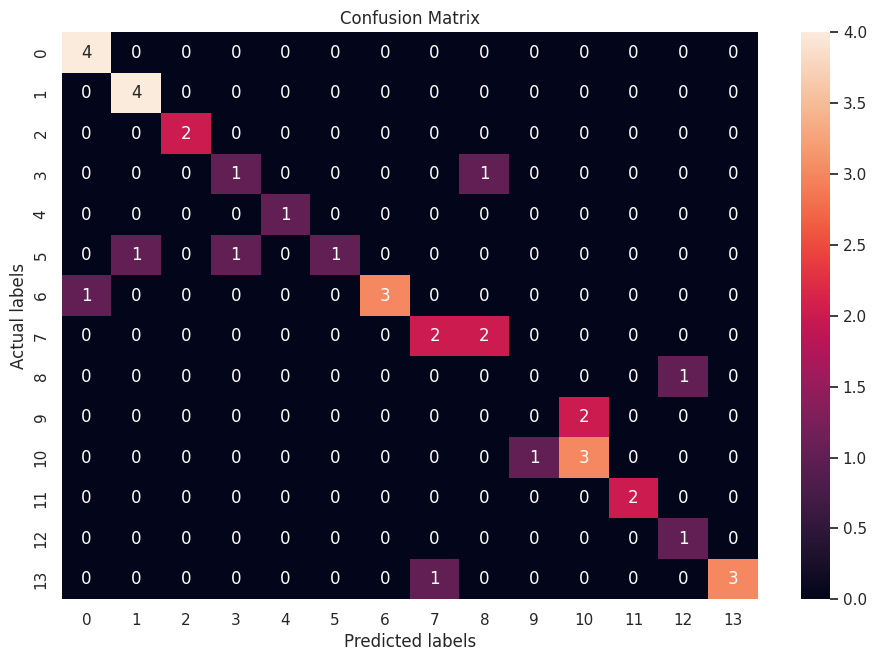

In [71]:
cm = confusion_matrix(y_test_argmax, pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

In [72]:
def perf_measure(y_test, y_pred):
    CM = confusion_matrix(y_test, y_pred)

    for i in range(5):
        #5 osztaly a ciklus alapjan
        print(str(le.inverse_transform([i]))," osztaly: " ,i+1)
        TP = CM[i][i]
        FP = CM[i,:].sum() - TP
        FN = CM[:,i].sum() - TP
        TN = CM[:,:].sum() - TP - FP - FN

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)

        # Specificity or true negative rate
        TNR = TN/(TN+FP)

        # PPV positive predictive value
        PPV = TP/(TP+FP)

        # NPV negative predictive value
        NPV = TN/(TN+FN)

        #Accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        #Dice score
        DS = (2*TP)/((2*TP)+FP+FN)

        print("True positive :", TP)
        print("True negative :", TN)
        print("False positive :", FP)
        print("False negative :", FN, '\n')

        print("True positive rate :", TPR)
        print("True negative rate :", TNR)
        print("Positive predictive value :", PPV)
        print("Negative predictive value :", NPV)
        print("Accuracy :", ACC)
        print("Dice score :", DS, '\n')

In [73]:
perf_measure(y_test_argmax, pred)

['bicycles_crossing']  osztaly:  1
True positive : 4
True negative : 33
False positive : 0
False negative : 1 

True positive rate : 0.8
True negative rate : 1.0
Positive predictive value : 1.0
Negative predictive value : 0.9705882352941176
Accuracy : 0.9736842105263158
Dice score : 0.8888888888888888 

['dont_go_left']  osztaly:  2
True positive : 4
True negative : 33
False positive : 0
False negative : 1 

True positive rate : 0.8
True negative rate : 1.0
Positive predictive value : 1.0
Negative predictive value : 0.9705882352941176
Accuracy : 0.9736842105263158
Dice score : 0.8888888888888888 

['keep_right']  osztaly:  3
True positive : 2
True negative : 36
False positive : 0
False negative : 0 

True positive rate : 1.0
True negative rate : 1.0
Positive predictive value : 1.0
Negative predictive value : 1.0
Accuracy : 1.0
Dice score : 1.0 

['no_car']  osztaly:  4
True positive : 1
True negative : 35
False positive : 1
False negative : 1 

True positive rate : 0.5
True negative ra

In [75]:
perf_measure_metrics(y_test_argmax, pred, cm, '/content/drive/My Drive/TrafficSignCNN/detailed_metrics-overfit.csv')